# Sentiment Classification Model 5

 Trained on IMDB dataset, predicts on WW2 Bunker Reviews. Fine-tuned on 100 manually classified reviews. Traind on roBERTa model.

### 1. Import Dependencies

In [6]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    Trainer, 
    TrainingArguments,
    RobertaTokenizer, 
    RobertaForSequenceClassification
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support





### 2. Load Data

In [7]:
df = pd.read_pickle("../data/processed/processed_movie_reviews.pkl")
df.head()

,review,sentiment,clean_text,tokens
0,One of the other reviewers has mentioned that ...,1,One of the other reviewers has mentioned that ...,"{'input_ids': [101, 2028, 1997, 1996, 2060, 15..."
1,A wonderful little production. <br /><br />The...,1,A wonderful little production. The filming tec...,"{'input_ids': [101, 1037, 6919, 2210, 2537, 10..."
2,I thought this was a wonderful way to spend ti...,1,I thought this was a wonderful way to spend ti...,"{'input_ids': [101, 1045, 2245, 2023, 2001, 10..."
3,Basically there's a family where a little boy ...,0,Basically there's a family where a little boy ...,"{'input_ids': [101, 10468, 2045, 1005, 1055, 1..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,Petter Mattei's Love in the Time of Money is a...,"{'input_ids': [101, 9004, 3334, 4717, 7416, 10..."


### 3. Prepare Train/Validation Splits

In [8]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["clean_text"], df["sentiment"], test_size=0.2, random_state=42
)

### 4. Create a Dataset Class

In [9]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist() if hasattr(texts, "tolist") else texts
        self.labels = labels.tolist() if hasattr(labels, "tolist") else labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }
        return item


### 5. Instansiate Tokenizer & Dataset

In [10]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

### 6. Initialize Model and Trainer

In [11]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

training_args = TrainingArguments(
    output_dir="outputs5",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="logs",
    logging_steps=50,
    bf16 = True if torch.backends.mps.is_available() else False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/homebrew/lib/python3.13/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### 7. Train

In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.425800,0.417804
2,0.308300,0.353757
3,0.280000,0.401114


TrainOutput(global_step=15000, training_loss=0.34760895125071206, metrics={'train_runtime': 13462.7397, 'train_samples_per_second': 8.913, 'train_steps_per_second': 1.114, 'total_flos': 7893331660800000.0, 'train_loss': 0.34760895125071206, 'epoch': 3.0})

In [13]:
model = RobertaForSequenceClassification.from_pretrained("outputs5/checkpoint-15000")  
# or "outputs" if that’s where you saved it

# Re-initialize the Trainer with the same arguments but the loaded model:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


In [14]:
val_preds = trainer.predict(val_dataset)


### Performance on Validation Set

In [15]:
logits = val_preds.predictions
labels = val_preds.label_ids

# Argmax over logits to get predicted class (0 or 1)
preds = np.argmax(logits, axis=1)

accuracy = (preds == labels).mean()


acc = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

print(f"Accuracy:   {acc:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1:         {f1:.4f}")


Accuracy:   0.8937
Precision:  0.9028
Recall:     0.8843
F1:         0.8934


### Confusion Matrix of Validation Set

[[4481  480]
 [ 583 4456]]


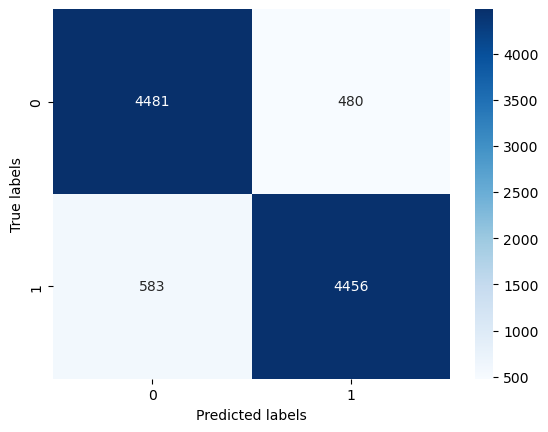

In [16]:
# `labels` = ground-truth labels (0 or 1)
# `preds` = predicted labels (0 or 1)

cm = confusion_matrix(labels, preds)
print(cm)

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
plt.show()



### 8. Evaluate

In [17]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.4011135399341583, 'eval_model_preparation_time': 0.0042, 'eval_runtime': 279.8903, 'eval_samples_per_second': 35.728, 'eval_steps_per_second': 4.466}


### 9. Fine-Tune the Model

### Change to predict 3 classes: Positive, Neutral and Negative

In [21]:
# Load existing pretrained IMDB model
model = RobertaForSequenceClassification.from_pretrained(
    "outputs5/checkpoint-15000",
    num_labels=3, 
    ignore_mismatched_sizes=True  
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at outputs5/checkpoint-15000 and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Fine-Tune explicity on sample of the WWII dataset (100 reviews)

In [22]:
bunker_df = pd.read_pickle("../data/processed/bunker_test_set_tokenized2.pkl")

bunker_texts = bunker_df["clean_text"]

label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
bunker_labels = bunker_df["manual_classification"].map(label_mapping)

bunker_train_dataset = SentimentDataset(bunker_texts, bunker_labels, tokenizer)

# Training arguments (reuse your existing settings or slightly adjust)
training_args = TrainingArguments(
    output_dir="outputs5_finetuned",
    num_train_epochs=3,  # Adjust as needed
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    learning_rate=2e-5
)

bunker_trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=bunker_train_dataset,
    eval_dataset=bunker_train_dataset 
)

bunker_trainer.train()

bunker_trainer.save_model("outputs5_finetuned/final_model")



/opt/homebrew/lib/python3.13/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.498629
2,No log,0.419171
3,No log,0.395573


### 9. Predict on WWII Dataset

In [24]:
model = RobertaForSequenceClassification.from_pretrained("outputs5_finetuned/final_model") 
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Save the final fine-tuned bunker model explicitly
bunker_trainer.save_model("outputs5_finetuned/final_model")


df_test = pd.read_pickle("../data/processed/bunker_test_set_tokenized.pkl")

class InferenceDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.texts = df["clean_text"].tolist()
        self.tokenizer = tokenizer
        self.max_length = 512  
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze()
        }

inference_dataset = InferenceDataset(df_test)

training_args = TrainingArguments(
    output_dir="outputs5",
    per_device_eval_batch_size=8
)
trainer = Trainer(
    model=model,
    args=training_args
)

predictions_output = trainer.predict(inference_dataset)
logits = predictions_output.predictions  # shape: (num_samples, 3)

probs = F.softmax(torch.tensor(logits), dim=1).numpy()

# Map predictions directly to three explicit sentiment classes
label_mapping = {0: "negative", 1: "neutral", 2: "positive"}
final_preds = [label_mapping[p.argmax()] for p in probs]

df_test["predicted_sentiment"] = final_preds

df_test = df_test[["clean_text", "manual_classification", "predicted_sentiment", "tokens"]]

df_test.to_csv("../data/processed/bunker_predictions.csv", index=False)
print("Predictions saved to data/processed/bunker_predictions.csv")

Predictions saved to data/processed/bunker_predictions.csv


### Distribution of Probabilities of Sentiment Classification

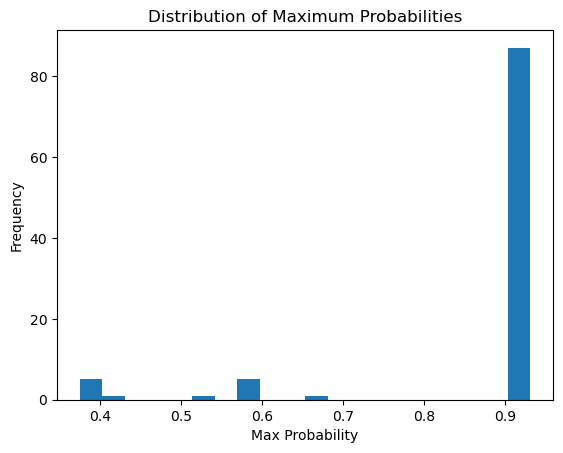

In [25]:
max_probs = [p.max() for p in probs]
plt.hist(max_probs, bins=20)
plt.xlabel("Max Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Maximum Probabilities")
plt.show()


### Performance on WWII Sample dataset (100 reviews manually classified)

In [26]:
df_test = pd.read_csv("../data/processed/bunker_predictions.csv")

manual_labels = df_test["manual_classification"]
predicted_labels = df_test["predicted_sentiment"]

accuracy = accuracy_score(manual_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

cm = confusion_matrix(manual_labels, predicted_labels, labels=["positive", "neutral", "negative"])
print("Confusion Matrix:")
print(cm)

report = classification_report(manual_labels, predicted_labels, labels=["positive", "neutral", "negative"])
print("Classification Report:")
print(report)


Accuracy: 0.8000
Confusion Matrix:
[[75  0  1]
 [14  0  0]
 [ 3  2  5]]
Classification Report:
              precision    recall  f1-score   support

    positive       0.82      0.99      0.89        76
     neutral       0.00      0.00      0.00        14
    negative       0.83      0.50      0.62        10

    accuracy                           0.80       100
   macro avg       0.55      0.50      0.51       100
weighted avg       0.70      0.80      0.74       100



In [ ]:
df_incorrect = df_test[df_test["manual_classification"] != df_test["predicted_sentiment"]]

df_incorrect.to_csv("incorrect_classifications.csv", index=False)
